## Baseline Model Fine-Tuning

### 1. Setup, Configuration and Device Setup

In [2]:
# way to fix the env for torch problems: paste:
# pip install --index-url https://download.pytorch.org/whl/cpu torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1

import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_large
from tqdm import tqdm
import matplotlib.pyplot as plt

# Add config directory to Python path for importing project settings
project_root = Path(r"C:\Users\Lejlum\Documents\PA2_Recycling_Chatbot\waste_recycling_chatbot_pa2\config")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import dataset path and model path from configuration file
from config import PROCESSED_NEW, BASELINE_MODEL

# Set device for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Lejlum\miniconda3\envs\pa2\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\Lejlum\miniconda3\envs\pa2\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


Using device: cpu


### 2. Random Seed Setup for Reproducibility

Setting consistent random seeds ensures reproducible training results across different runs by fixing randomness in PyTorch, NumPy, and Python's random module.

In [3]:
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Seeds set with SEED={SEED}")

Seeds set with SEED=42


### 3. Data Transformations

Data transformations define how images are preprocessed before feeding them to the model. Training uses augmentation techniques to improve model generalization, while validation uses only basic preprocessing for consistent evaluation.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)), # Augmentation: random crop with scaling
    transforms.RandomHorizontalFlip(p=0.5),               # Augmentation: horizontal flip
    transforms.RandomRotation(25),                        # Augmentation: random rotation up to ±25°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # Augmentation: color and brightness jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Augmentation: random translation
    transforms.GaussianBlur(3, sigma=(0.1, 1.5)),         # Augmentation: Gaussian blur
    transforms.ToTensor(),                                # Convert to tensor
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),  # Augmentation: random erasing
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize (ImageNet statistics)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize for validation
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize (ImageNet statistics)
])

### 4. Load Dataset

Dataset loading creates PyTorch datasets from the organized directory structure and wraps them in DataLoaders for efficient batch processing during training and evaluation.

In [5]:
# Load datasets from organized directory structure
DATA_PATH = PROCESSED_NEW

train_data = datasets.ImageFolder(f"{DATA_PATH}/train", transform=train_transform)
val_data = datasets.ImageFolder(f"{DATA_PATH}/val", transform=val_transform)
test_data = datasets.ImageFolder(f"{DATA_PATH}/test", transform=val_transform)

# Create data loaders with appropriate batch size
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)      # Shuffle for training
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)         # No shuffle for validation
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)       # No shuffle for testing

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")
print(f"Classes: {train_data.classes}")

Train: 4056 | Val: 869 | Test: 870
Classes: ['aluminium', 'brown_glass', 'cardboard', 'composite_carton', 'green_glass', 'hazardous_waste_(battery)', 'metal', 'organic_waste', 'paper', 'pet', 'plastic', 'plastic_aluminium', 'residual_waste', 'rigid_plastic_container', 'white_glass', 'white_glass_metal']


### 5. Load Pretrained Model

Model initialization sets up the MobileNetV3 architecture with a custom classifier for waste classification. Pretrained weights from a baseline model are loaded for the feature extractor while the final classification layer is randomly initialized for the new task.

In [6]:
# Initialize MobileNetV3 architecture and modify classifier for waste classification
model = mobilenet_v3_large(weights=None)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 1280),
    nn.Hardswish(),
    nn.Dropout(0.2),
    nn.Linear(1280, 16)  # Output layer for 16 waste categories (originally 10)
)

# Load pretrained model weights from baseline model
state_dict = torch.load(BASELINE_MODEL, map_location='cpu', weights_only=False)

# Extract model state dictionary if nested
if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
    pretrained_state_dict = state_dict['model_state_dict']
else:
    pretrained_state_dict = state_dict

# Remove final classification layer from pretrained weights (incompatible dimensions)
pretrained_state_dict = {k: v for k, v in pretrained_state_dict.items() 
                        if not k.startswith('classifier.3')}

# Load compatible weights (feature extractor + partial classifier)
model.load_state_dict(pretrained_state_dict, strict=False)

# Move model to available device
model = model.to(device)
print("Feature extractor weights loaded successfully, classifier initialized randomly")

Feature extractor weights loaded successfully, classifier initialized randomly


### 6. Early Stopping Implementation

Early stopping prevents overfitting by monitoring validation loss and stopping training when performance stops improving. It saves the best model weights and can restore them after training completes.

In [7]:
class EarlyStopping:
    """Early stopping utility to prevent overfitting during training"""
    
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_val_loss = float('inf')
        self.counter = 0
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        print(f"[EarlyStopping] Current val_loss: {val_loss:.4f}, Best: {self.best_val_loss:.4f}")
        
        if val_loss < self.best_val_loss - self.min_delta:
            print(f"[EarlyStopping] New best! Resetting counter. Improvement: {self.best_val_loss - val_loss:.4f}")
            self.best_val_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = model.state_dict().copy()
            return False  # Continue training
        else:
            self.counter += 1
            print(f"[EarlyStopping] No improvement. Counter: {self.counter}/{self.patience}")
            return self.counter >= self.patience  # Stop training
    
    def restore_best_model(self, model):
        """Restore the best model weights found during training"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("Best model weights restored!")
        else:
            print("No best model state saved!")

### 7. Training Configuration

Training configuration sets up the loss function, optimizer, and training parameters. Early stopping is initialized to monitor training progress and prevent overfitting.

In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

EPOCHS = 30

early_stopping = EarlyStopping(patience=5, min_delta=0.005, restore_best_weights=True)

### 8. Training and Validation Functions

Training and validation functions implement the core training loop. The training function handles forward pass, loss calculation, backpropagation and parameter updates, while validation evaluates model performance without gradient updates.

In [9]:
def train_epoch(model, loader, criterion, optimizer, scheduler=None, max_grad_norm=1.0):
    """Train model for one epoch with gradient clipping and learning rate scheduling"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler is not None:
        scheduler.step()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    """Validate model performance without gradient updates"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

### 9. Training Loop with Early Stopping

The main training loop executes the training process for multiple epochs, tracking performance metrics and implementing early stopping to prevent overfitting. Training history is recorded for later analysis and visualization.

In [10]:
# Initialize training history tracking
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Execute training and validation for current epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler=scheduler)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record metrics in training history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Display epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Check early stopping condition
    if early_stopping(val_loss, model):
        print(f"EARLY STOPPING TRIGGERED at epoch {epoch+1}")
        print(f"Best validation loss was: {early_stopping.best_val_loss:.4f}")
        print(f"Training stopped {EPOCHS - (epoch+1)} epochs early")
        break

# Restore best model weights after training completion
early_stopping.restore_best_model(model)
print(f"Training completed after {len(history['val_loss'])} epochs")
print("Restored best model weights")


Epoch 1/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s]


Train Loss: 1.4788 | Train Acc: 65.36%
Val Loss: 1.2581 | Val Acc: 74.45%
[EarlyStopping] Current val_loss: 1.2581, Best: inf
[EarlyStopping] New best! Resetting counter. Improvement: inf

Epoch 2/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]


Train Loss: 1.1104 | Train Acc: 80.40%
Val Loss: 1.0889 | Val Acc: 82.74%
[EarlyStopping] Current val_loss: 1.0889, Best: 1.2581
[EarlyStopping] New best! Resetting counter. Improvement: 0.1692

Epoch 3/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]


Train Loss: 1.0035 | Train Acc: 84.52%
Val Loss: 1.1511 | Val Acc: 80.55%
[EarlyStopping] Current val_loss: 1.1511, Best: 1.0889
[EarlyStopping] No improvement. Counter: 1/5

Epoch 4/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.61it/s]


Train Loss: 0.9522 | Train Acc: 86.88%
Val Loss: 1.1855 | Val Acc: 75.60%
[EarlyStopping] Current val_loss: 1.1855, Best: 1.0889
[EarlyStopping] No improvement. Counter: 2/5

Epoch 5/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]


Train Loss: 0.9000 | Train Acc: 88.86%
Val Loss: 1.0859 | Val Acc: 82.85%
[EarlyStopping] Current val_loss: 1.0859, Best: 1.0889
[EarlyStopping] No improvement. Counter: 3/5

Epoch 6/30


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Train Loss: 0.8565 | Train Acc: 90.56%
Val Loss: 0.9267 | Val Acc: 87.80%
[EarlyStopping] Current val_loss: 0.9267, Best: 1.0889
[EarlyStopping] New best! Resetting counter. Improvement: 0.1623

Epoch 7/30


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Train Loss: 0.8246 | Train Acc: 91.96%
Val Loss: 0.9754 | Val Acc: 85.04%
[EarlyStopping] Current val_loss: 0.9754, Best: 0.9267
[EarlyStopping] No improvement. Counter: 1/5

Epoch 8/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


Train Loss: 0.7840 | Train Acc: 93.93%
Val Loss: 0.9054 | Val Acc: 88.72%
[EarlyStopping] Current val_loss: 0.9054, Best: 0.9267
[EarlyStopping] New best! Resetting counter. Improvement: 0.0212

Epoch 9/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Train Loss: 0.7604 | Train Acc: 94.16%
Val Loss: 0.8768 | Val Acc: 89.87%
[EarlyStopping] Current val_loss: 0.8768, Best: 0.9054
[EarlyStopping] New best! Resetting counter. Improvement: 0.0286

Epoch 10/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Train Loss: 0.7386 | Train Acc: 95.49%
Val Loss: 0.8745 | Val Acc: 90.22%
[EarlyStopping] Current val_loss: 0.8745, Best: 0.8768
[EarlyStopping] No improvement. Counter: 1/5

Epoch 11/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Train Loss: 0.7076 | Train Acc: 96.45%
Val Loss: 0.8162 | Val Acc: 92.29%
[EarlyStopping] Current val_loss: 0.8162, Best: 0.8768
[EarlyStopping] New best! Resetting counter. Improvement: 0.0606

Epoch 12/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Train Loss: 0.6710 | Train Acc: 97.68%
Val Loss: 0.8275 | Val Acc: 91.37%
[EarlyStopping] Current val_loss: 0.8275, Best: 0.8162
[EarlyStopping] No improvement. Counter: 1/5

Epoch 13/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Train Loss: 0.6558 | Train Acc: 98.40%
Val Loss: 0.8025 | Val Acc: 92.06%
[EarlyStopping] Current val_loss: 0.8025, Best: 0.8162
[EarlyStopping] New best! Resetting counter. Improvement: 0.0137

Epoch 14/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Train Loss: 0.6411 | Train Acc: 99.01%
Val Loss: 0.7709 | Val Acc: 92.75%
[EarlyStopping] Current val_loss: 0.7709, Best: 0.8025
[EarlyStopping] New best! Resetting counter. Improvement: 0.0316

Epoch 15/30


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Train Loss: 0.6255 | Train Acc: 99.26%
Val Loss: 0.7583 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7583, Best: 0.7709
[EarlyStopping] New best! Resetting counter. Improvement: 0.0126

Epoch 16/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Train Loss: 0.6154 | Train Acc: 99.48%
Val Loss: 0.7512 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7512, Best: 0.7583
[EarlyStopping] New best! Resetting counter. Improvement: 0.0071

Epoch 17/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Train Loss: 0.6100 | Train Acc: 99.70%
Val Loss: 0.7469 | Val Acc: 93.33%
[EarlyStopping] Current val_loss: 0.7469, Best: 0.7512
[EarlyStopping] No improvement. Counter: 1/5

Epoch 18/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.56it/s]


Train Loss: 0.6111 | Train Acc: 99.61%
Val Loss: 0.7445 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7445, Best: 0.7512
[EarlyStopping] New best! Resetting counter. Improvement: 0.0067

Epoch 19/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.59it/s]


Train Loss: 0.6090 | Train Acc: 99.48%
Val Loss: 0.7428 | Val Acc: 93.67%
[EarlyStopping] Current val_loss: 0.7428, Best: 0.7445
[EarlyStopping] No improvement. Counter: 1/5

Epoch 20/30


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


Train Loss: 0.6064 | Train Acc: 99.70%
Val Loss: 0.7432 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7432, Best: 0.7445
[EarlyStopping] No improvement. Counter: 2/5

Epoch 21/30


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Train Loss: 0.6031 | Train Acc: 99.78%
Val Loss: 0.7427 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7427, Best: 0.7445
[EarlyStopping] No improvement. Counter: 3/5

Epoch 22/30


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Train Loss: 0.6033 | Train Acc: 99.68%
Val Loss: 0.7422 | Val Acc: 93.56%
[EarlyStopping] Current val_loss: 0.7422, Best: 0.7445
[EarlyStopping] No improvement. Counter: 4/5

Epoch 23/30


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.59it/s]

Train Loss: 0.6047 | Train Acc: 99.61%
Val Loss: 0.7415 | Val Acc: 93.67%
[EarlyStopping] Current val_loss: 0.7415, Best: 0.7445
[EarlyStopping] No improvement. Counter: 5/5
EARLY STOPPING TRIGGERED at epoch 23
Best validation loss was: 0.7445
Training stopped 7 epochs early
Best model weights restored!
Training completed after 23 epochs
Restored best model weights


### 10. Model Saving

Model saving preserves the trained model weights, optimizer state, and training history for future use or deployment. This checkpoint includes all necessary information to resume training or perform inference.

In [11]:
from config import FINAL_MODEL_DIR

FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, FINAL_MODEL_DIR / 'finetuned_model.pth')

print(f"Model saved to {FINAL_MODEL_DIR / 'finetuned_model.pth'}")

Model saved to C:\Users\Lejlum\Documents\PA2_Recycling_Chatbot\waste_recycling_chatbot_pa2\models\baseline\finetuned_model.pth


### 11. Training History Visualization

Visualizing training and validation metrics throughout epochs helps identify model convergence behavior, overfitting, and confirms that early stopping worked correctly.

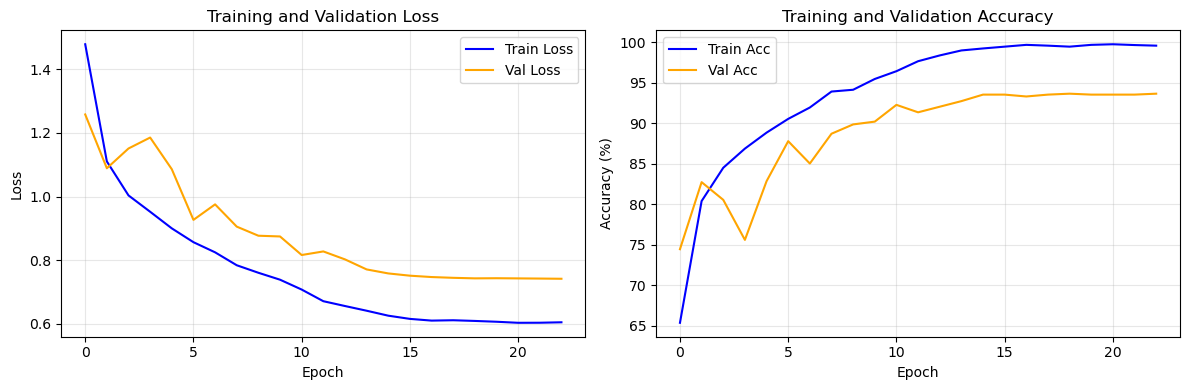

Training history plot saved to C:\Users\Lejlum\Documents\PA2_Recycling_Chatbot\waste_recycling_chatbot_pa2\outputs\figures\training_history.png


In [12]:
# Import config for organized file saving
from config import FIGURES_DIR

# Create figures directory if it doesn't exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Create subplot layout for training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(history['train_loss'], label='Train Loss', color='blue')
ax1.plot(history['val_loss'], label='Val Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(history['train_acc'], label='Train Acc', color='blue')
ax2.plot(history['val_acc'], label='Val Acc', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.grid(True, alpha=0.3)

# Save to organized output directory
plt.tight_layout()
figure_path = FIGURES_DIR / 'training_history.png'
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {figure_path}")

### 12. Final Model Evaluation

Final evaluation tests the optimized model on unseen test data to measure real-world performance and confirm that improvements achieved during training generalize to new samples.

In [13]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Validation: 100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Test Loss: 0.7106 | Test Acc: 95.29%


### 13. Detailed Evaluation with Confusion Matrix

Detailed analysis collects model predictions on the test set and prepares data for comprehensive evaluation metrics including confusion matrix and classification report to understand per-class performance.

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect all predictions and labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions on test set
test_preds, test_labels = get_predictions(model, test_loader)

### 14. Confusion Matrix Visualization

The confusion matrix provides detailed insights into model performance for each waste category, showing which classes are correctly classified and where misclassifications occur most frequently.

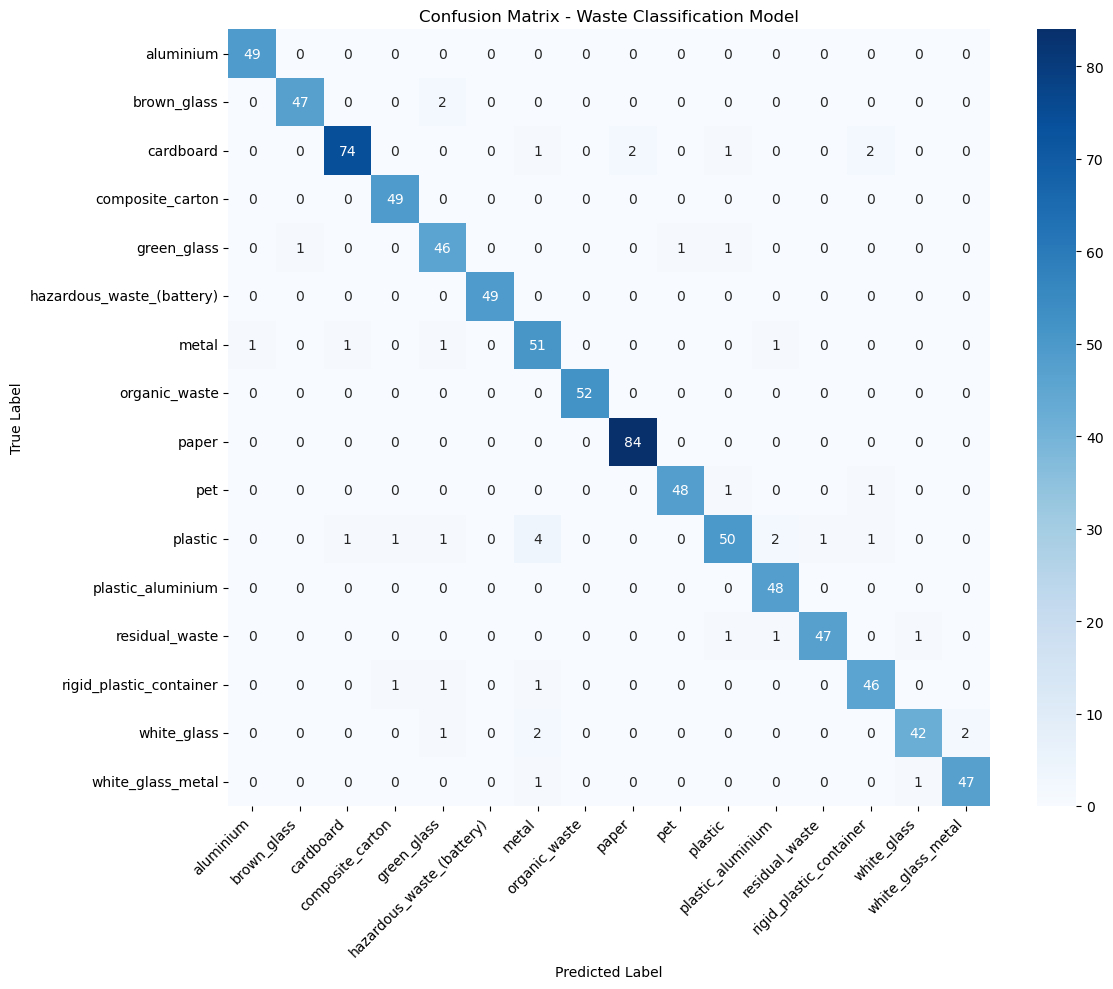

Confusion matrix saved to C:\Users\Lejlum\Documents\PA2_Recycling_Chatbot\waste_recycling_chatbot_pa2\outputs\figures\confusion_matrix.png


In [15]:
# Generate confusion matrix from test predictions
cm = confusion_matrix(test_labels, test_preds)
actual_classes = train_data.classes 

# Create confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=actual_classes, 
            yticklabels=actual_classes)
plt.title('Confusion Matrix - Waste Classification Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Save to config-defined figures directory
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to {FIGURES_DIR / 'confusion_matrix.png'}")

### 15. Per-Class Accuracy

Per-class analysis breaks down model performance for each waste category, revealing which materials are classified most accurately and identifying potential areas for improvement.

In [16]:
print("\nPer-Class Performance:")
print("=" * 60)

# Calculate accuracy for each waste category
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_accuracy = 100. * class_correct / class_total

# Get actual classes from test set
actual_classes = [train_data.classes[i] for i in np.unique(test_labels)]

# Display detailed per-class results
for i, class_name in enumerate(actual_classes):
    print(f"{class_name:<25} Accuracy: {class_accuracy[i]:>6.2f}% ({class_correct[i]}/{class_total[i]})")

print("=" * 60)
print(f"Overall Test Accuracy: {100. * class_correct.sum() / class_total.sum():.2f}%")

# Find all classes with perfect performance
perfect_classes = [actual_classes[i] for i, acc in enumerate(class_accuracy) if acc == 100.0]
worst_class_idx = np.argmin(class_accuracy)

print(f"\nPerfect performing classes (100%): {', '.join(perfect_classes)}")
print(f"Worst performing class: {actual_classes[worst_class_idx]} ({class_accuracy[worst_class_idx]:.2f}%)")


Per-Class Performance:
aluminium                 Accuracy: 100.00% (49/49)
brown_glass               Accuracy:  95.92% (47/49)
cardboard                 Accuracy:  92.50% (74/80)
composite_carton          Accuracy: 100.00% (49/49)
green_glass               Accuracy:  93.88% (46/49)
hazardous_waste_(battery) Accuracy: 100.00% (49/49)
metal                     Accuracy:  92.73% (51/55)
organic_waste             Accuracy: 100.00% (52/52)
paper                     Accuracy: 100.00% (84/84)
pet                       Accuracy:  96.00% (48/50)
plastic                   Accuracy:  81.97% (50/61)
plastic_aluminium         Accuracy: 100.00% (48/48)
residual_waste            Accuracy:  94.00% (47/50)
rigid_plastic_container   Accuracy:  93.88% (46/49)
white_glass               Accuracy:  89.36% (42/47)
white_glass_metal         Accuracy:  95.92% (47/49)
Overall Test Accuracy: 95.29%

Perfect performing classes (100%): aluminium, composite_carton, hazardous_waste_(battery), organic_waste, paper, 

### 16. Classification Report

The classification report provides comprehensive per-class metrics including precision, recall, and F1-score, offering deeper insights into model performance beyond simple accuracy measurements.

In [17]:
print("\nDetailed Classification Report:")
print("=" * 80)
print(classification_report(test_labels, test_preds, 
                          target_names=actual_classes,  # Use actual_classes from previous analysis
                          digits=3))


Detailed Classification Report:
                           precision    recall  f1-score   support

                aluminium      0.980     1.000     0.990        49
              brown_glass      0.979     0.959     0.969        49
                cardboard      0.974     0.925     0.949        80
         composite_carton      0.961     1.000     0.980        49
              green_glass      0.885     0.939     0.911        49
hazardous_waste_(battery)      1.000     1.000     1.000        49
                    metal      0.850     0.927     0.887        55
            organic_waste      1.000     1.000     1.000        52
                    paper      0.977     1.000     0.988        84
                      pet      0.980     0.960     0.970        50
                  plastic      0.926     0.820     0.870        61
        plastic_aluminium      0.923     1.000     0.960        48
           residual_waste      0.979     0.940     0.959        50
  rigid_plastic_container   

### 17. Automated Misclassification Detection and Organization

This code systematically organizes misclassified images by copying them into a dedicated directory with descriptive filenames that clearly indicate both the true label and predicted label, facilitating targeted analysis of model errors and supporting iterative model improvement efforts.

In [18]:
import shutil
from pathlib import Path

misclassified_dir = FIGURES_DIR / 'misclassified'
misclassified_dir.mkdir(parents=True, exist_ok=True)

misclassified_count = 0

for idx, (true_idx, pred_idx) in enumerate(zip(test_labels, test_preds)):
    if true_idx != pred_idx:
        true_label = actual_classes[true_idx]
        pred_label = actual_classes[pred_idx]
        
        img_path = Path(test_data.samples[idx][0])
        new_filename = f"{true_label}_predicted_as_{pred_label}_{img_path.name}"
        
        shutil.copy(img_path, misclassified_dir / new_filename)
        misclassified_count += 1

print(f"\nCopied {misclassified_count} misclassified images to {misclassified_dir}")
print("Images are named as 'true_label_predicted_as_pred_label_original_name'.")



Copied 41 misclassified images to C:\Users\Lejlum\Documents\PA2_Recycling_Chatbot\waste_recycling_chatbot_pa2\outputs\figures\misclassified
Images are named as 'true_label_predicted_as_pred_label_original_name'.


### 18. Comprehensive Misclassification Logging and Documentation

Lastely, this code creates a detailed CSV log of all misclassified images by collecting metadata including file paths, indices, true labels, and predicted labels into a structured DataFrame, enabling systematic tracking and analysis of classification errors for comprehensive model evaluation and debugging.

In [19]:
import pandas as pd

records = []

for idx, (true_idx, pred_idx) in enumerate(zip(test_labels, test_preds)):
    if true_idx != pred_idx:
        true_label = actual_classes[true_idx]
        pred_label = actual_classes[pred_idx]
        img_path = Path(test_data.samples[idx][0])

        records.append({
            "idx": idx,
            "file": img_path.name,
            "path": str(img_path),
            "true_label": true_label,
            "pred_label": pred_label
        })

df_mis = pd.DataFrame(records)
df_mis.to_csv(FIGURES_DIR / "misclassified_log.csv", index=False)
df_mis.head()

,idx,file,path,true_label,pred_label
0,66,3062.jpg,C:\Users\Lejlum\Documents\PA2_Recycling_Chatbo...,brown_glass,green_glass
1,97,6976.jpg,C:\Users\Lejlum\Documents\PA2_Recycling_Chatbo...,brown_glass,green_glass
2,99,0029.jpg,C:\Users\Lejlum\Documents\PA2_Recycling_Chatbo...,cardboard,rigid_plastic_container
3,140,0519.jpg,C:\Users\Lejlum\Documents\PA2_Recycling_Chatbo...,cardboard,plastic
4,161,0623.jpg,C:\Users\Lejlum\Documents\PA2_Recycling_Chatbo...,cardboard,metal
